In [ ]:
import pandas as pd

df = pd.read_csv("English_profanity_words.csv")
df.head()

In [1]:
from transformers import pipeline
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import cross_entropy
from tqdm import tqdm

# Check for MPS device and set it as the default device if available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained("JungleLee/bert-toxic-comment-classification")
model = AutoModelForSequenceClassification.from_pretrained("JungleLee/bert-toxic-comment-classification")

# Define the pipeline with model and tokenizer
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if device.type == "mps" else -1
)

# Load the CSV data
data = pd.read_csv("English_profanity_words.csv")

# Remove rows with NaN or missing values in 'text' or 'is_offensive' columns
data = data.dropna(subset=['text', 'is_offensive'])

# Ensure that all entries in 'text' are of string type
data['text'] = data['text'].astype(str)


# Define a simple dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Prepare data
texts = data["text"].tolist()
labels = data["is_offensive"].tolist()
dataset = TextDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=8)

# Set model to evaluation mode
model.eval()

# Move model to MPS if available
model.to(device)

# Initialize lists to store true and predicted labels
all_labels = []
all_preds = []
losses = []

# Evaluate model
with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = cross_entropy(logits, labels)
        losses.append(loss.item())

        # Get predictions
        preds = torch.argmax(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics
average_loss = sum(losses) / len(losses)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print the results
print(f"Loss: {average_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Using device: mps


100%|██████████| 23044/23044 [24:33<00:00, 15.64it/s]


Loss: 0.2929
Accuracy: 0.9351
Precision: 0.7836
Recall: 0.9332
F1 Score: 0.8519


In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [5]:
sample_labels = np.array(all_labels) if 'all_labels' in locals() else np.random.randint(0, 2, 100)
sample_preds = np.array(all_preds) if 'all_preds' in locals() else np.random.randint(0, 2, 100)
cm = confusion_matrix(sample_labels, sample_preds)

<Figure size 800x600 with 0 Axes>

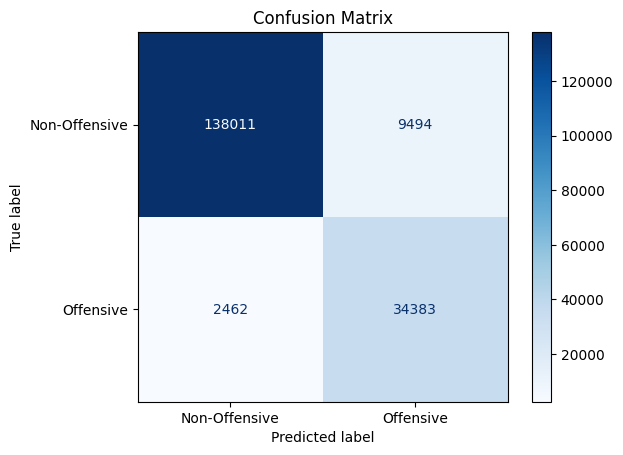

In [6]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=["Non-Offensive", "Offensive"]).plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Check for MPS device and set it as the default device if available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("JungleLee/bert-toxic-comment-classification")
model = AutoModelForSequenceClassification.from_pretrained("JungleLee/bert-toxic-comment-classification")
model.to(device)

# Load the CSV data
data = pd.read_csv("English_profanity_words.csv")
data = data.dropna(subset=['text', 'is_offensive'])  # Remove rows with NaN in 'text' or 'is_offensive'
data['text'] = data['text'].astype(str)  # Ensure all entries in 'text' are strings

# Stratified split of the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["text"].tolist(), data["is_offensive"].tolist(), test_size=0.2, stratify=data["is_offensive"], random_state=42
)

# Define a dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Create DataLoader for train and validation sets
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)

# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Fine-tune the model
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Training Loss: {avg_loss:.4f}")

# Evaluation on validation set
model.eval()
val_losses = []
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = torch.nn.functional.cross_entropy(logits, labels)
        val_losses.append(loss.item())

        # Get predictions
        preds = torch.argmax(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics
average_loss = np.mean(val_losses)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print the results
print(f"Validation Loss: {average_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Using device: mps


/Users/ethan/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


100%|██████████| 18435/18435 [1:12:10<00:00,  4.26it/s]


Training Loss: 0.0862
Epoch 2/3


100%|██████████| 18435/18435 [1:13:35<00:00,  4.18it/s]


Training Loss: 0.0472
Epoch 3/3


100%|██████████| 18435/18435 [1:11:13<00:00,  4.31it/s]


Training Loss: 0.0165


100%|██████████| 4609/4609 [04:49<00:00, 15.90it/s]

Validation Loss: 0.1289
Accuracy: 0.9694
Precision: 0.9317
Recall: 0.9141
F1 Score: 0.9228


In [2]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("bert_fine_tuned_model")
tokenizer.save_pretrained("bert_fine_tuned_model")
print("Model and tokenizer saved to 'fine_tuned_model' directory.")


Model and tokenizer saved to 'fine_tuned_model' directory.
